In [8]:
import pandas as pd
import numpy as np
import ipaddress
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils import class_weight
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [9]:
train_dataset_path = 'dataset/Wednesday-workingHours.pcap_ISCX.csv'
test_dataset_path = 'dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'

train_data = pd.read_csv(train_dataset_path)
test_data = pd.read_csv(test_dataset_path)

In [ ]:
# IP 주소를 정수로 변환하는 함수
def convert_ip2int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return 0

# 데이터 전처리 및 시계열 데이터 생성 함수
def preprocess_and_create_sequences(data, time_window='1T', time_steps=10):
    df = data.copy()
    # 컬럼 이름 정리 및 결측치 처리
    df.columns = df.columns.str.strip().str.replace('[ /]', '_', regex=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # 타임스탬프 변환 및 IP 주소 정수 변환
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df.dropna(subset=['Timestamp'], inplace=True)
    
    df['Source_IP'] = df['Source_IP'].astype(str).apply(convert_ip2int)
    df['Destination_IP'] = df['Destination_IP'].astype(str).apply(convert_ip2int)
    df.drop(columns=['Flow_ID'], inplace=True)

    # 라벨 변환 및 집계
    df.set_index('Timestamp', inplace=True)
    df['Label'] = np.where(df['Label'] == 'BENIGN', 0, 1)

    # 집계 함수 정의
    agg_funcs = {col: 'mean' for col in df.columns if col not in ['Label', 'Source_IP', 'Destination_IP']}
    agg_funcs['Total_Fwd_Packets'] = 'sum' # 분 단위 패킷의 합
    agg_funcs['Total_Backward_Packets'] = 'sum' # 분 단위 패킷의 합
    agg_funcs['Total_Length_of_Fwd_Packets'] = 'sum' # 분 단위 패킷의 합
    agg_funcs['Label'] = 'max' # 해당 분에 하나라도 공격이 있으면 1로 표시
    agg_funcs['Source_IP'] = 'nunique' # 고유한 Source IP의 개수
    agg_funcs['Destination_IP'] = 'nunique' # 고유한 Destination IP의 개수

    # time window(1분)에 따라 데이터 집계
    df_agg = df.resample(time_window).agg(agg_funcs)
    df_agg.fillna(0, inplace=True)

    X_agg = df_agg.drop('Label', axis=1).values
    y_agg = df_agg['Label'].values
    
    # 10분 단위의 시계열 데이터 생성
    X_seq, y_seq = [], []
    for i in range(len(X_agg) - time_steps):
        X_seq.append(X_agg[i:(i + time_steps)])
        y_seq.append(y_agg[i + time_steps - 1])
        
    return np.array(X_seq), np.array(y_seq)

# 하이퍼파라미터 정의
TIME_STEPS = 10
TIME_WINDOW = '1T'

print("데이터 전처리 및 시계열 데이터 생성 시작...")
X_train_seq, y_train_seq = preprocess_and_create_sequences(train_data, time_window=TIME_WINDOW, time_steps=TIME_STEPS)
X_test_seq, y_test_seq = preprocess_and_create_sequences(test_data, time_window=TIME_WINDOW, time_steps=TIME_STEPS)
print("데이터 전처리 및 시계열 데이터 생성 완료.")

print(f"Train 데이터 형태: {X_train_seq.shape}")
print(f"Test 데이터 형태: {X_test_seq.shape}")
print("-" * 50)



데이터 전처리 및 시계열 데이터 생성 시작...


C:\Users\bell1\AppData\Local\Temp\ipykernel_10704\3958384918.py:54: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_agg = df.resample(time_window).agg(agg_funcs)
C:\Users\bell1\AppData\Local\Temp\ipykernel_10704\3958384918.py:54: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_agg = df.resample(time_window).agg(agg_funcs)


데이터 전처리 및 시계열 데이터 생성 완료.
Train 데이터 형태: (710, 10, 82)
Test 데이터 형태: (83, 10, 82)
--------------------------------------------------


In [11]:
# 데이터 스케일링
n_samples, n_timesteps, n_features = X_train_seq.shape
X_train_reshaped = X_train_seq.reshape(-1, n_features)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train_lstm = X_train_scaled.reshape(n_samples, n_timesteps, n_features)

n_samples_test, _, _ = X_test_seq.shape
X_test_reshaped = X_test_seq.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_lstm = X_test_scaled.reshape(n_samples_test, n_timesteps, n_features)


In [12]:
def create_lstm_model(lstm_units=100, dense_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weights_dict = dict(enumerate(class_weights))
print(f"클래스 가중치: {class_weights_dict}")


클래스 가중치: {0: np.float64(0.5689102564102564), 1: np.float64(4.127906976744186)}


In [13]:
# LSTM 모델 및 GridSearchCV 정의
lstm_model = KerasClassifier(build_fn=create_lstm_model, verbose=0)
grid_params = {'epochs': [10, 25], 'batch_size': [64, 128]}

grid_search = GridSearchCV(estimator=lstm_model, param_grid=grid_params, cv=3, scoring='f1', verbose=1)
grid_search.fit(X_train_lstm, y_train_seq, class_weight=class_weights_dict)

print("최적의 파라미터:", grid_search.best_params_)
lstm_best_model = grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\projects\UGRP_prac\venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\projects\UGRP_prac\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\projects\UGRP_prac\venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\projects\UGRP_prac\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as

c:\projects\UGRP_prac\venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\projects\UGRP_prac\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\projects\UGRP_prac\venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\projects\UGRP_prac\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as

최적의 파라미터: {'batch_size': 64, 'epochs': 10}


In [14]:
print("\n최적 모델 학습 시작...")
start_time = time.time()
# GridSearchCV는 최적 파라미터로 모델을 자동 재학습(refit)하므로, 이 fit은 시간 측정용입니다.
lstm_best_model.fit(X_train_lstm, y_train_seq, class_weight=class_weights_dict)
end_time = time.time()
print(f"모델 학습 시간: {end_time - start_time:.4f} 초")


최적 모델 학습 시작...


c:\projects\UGRP_prac\venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\projects\UGRP_prac\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


모델 학습 시간: 1.7215 초


In [15]:
y_pred_lstm_proba = lstm_best_model.predict(X_test_lstm)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int)

print("\n[LSTM 모델 최적화 결과]")
print(f" - 하이퍼파라미터: {grid_search.best_params_}")
print(f" - 정확도 (Accuracy): {accuracy_score(y_test_seq, y_pred_lstm):.4f}")
print(f" - 재현율 (Recall): {recall_score(y_test_seq, y_pred_lstm):.4f}")
print(f" - 정밀도 (Precision): {precision_score(y_test_seq, y_pred_lstm):.4f}")
print(f" - F1-Score: {f1_score(y_test_seq, y_pred_lstm):.4f}")
print(f" - 학습 시간: {end_time - start_time:.4f}초")


[LSTM 모델 최적화 결과]
 - 하이퍼파라미터: {'batch_size': 64, 'epochs': 10}
 - 정확도 (Accuracy): 0.9157
 - 재현율 (Recall): 0.9524
 - 정밀도 (Precision): 0.7692
 - F1-Score: 0.8511
 - 학습 시간: 1.7215초


[예측 확률값 통계]
count    83.000000
mean      0.313253
std       0.466636
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
dtype: float64


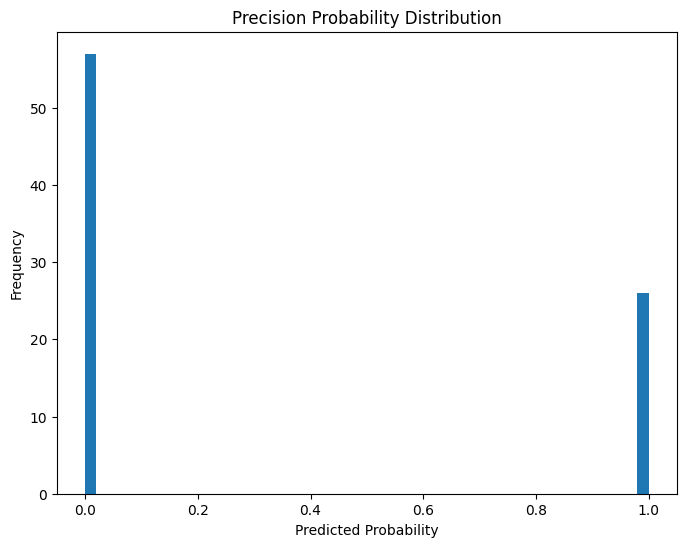

In [16]:
print("[예측 확률값 통계]")
print(pd.Series(y_pred_lstm_proba.flatten()).describe())

plt.figure(figsize=(8, 6))
plt.hist(y_pred_lstm_proba, bins=50)
plt.title("Precision Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

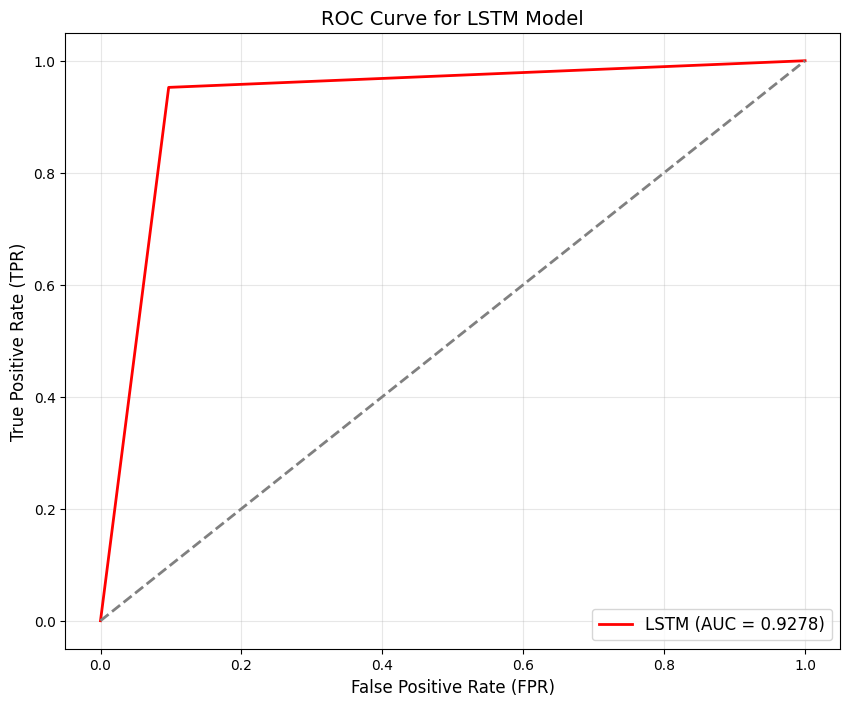

In [17]:
## ROC 곡선 및 AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_lstm_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='red', lw=2, label=f'LSTM (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for LSTM Model', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()